In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.externals import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier


%matplotlib inline

from utils.clean_utils import reduce_dataframe

# 1. Read Data

In [2]:
df_raw = pd.read_csv('data/feats_out.csv')

/Users/seramirchandani/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (8,24,29,30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# 2. Reduce Data

In [3]:
df = reduce_dataframe(df_raw)

# 3. Cleaning

In [4]:
columns = df.columns

In [5]:
df.describe()

,feat_nuc_region_mean_px,feat_nuc_region_median_px,feat_nuc_region_mode_px,feat_nuc_region_min_px,feat_nuc_region_max_px,feat_nuc_region_std_px,feat_nuc_region_entropy_px,feat_nuc_region_histogram_px_1,feat_nuc_region_histogram_px_2,feat_nuc_region_histogram_px_3,...,feat_nuc_obj_mean_degree,feat_nuc_obj_std_degree,feat_nuc_obj_tot_sphericity,feat_nuc_obj_max_spherical_obj,feat_nuc_obj_mean_spherical_obj,feat_nuc_obj_std_spherical_obj,feat_nuc_obj_eigval_1,feat_nuc_obj_eigval_2,feat_nuc_obj_eigval_3,feat_nuc_obj_tot_height
count,21793.000000,21793.000000,2.179300e+04,2.179300e+04,21793.000000,21793.000000,21793.000000,21793.000000,21793.000000,21793.000000,...,21793.000000,21793.000000,21793.000000,21793.000000,21793.000000,21793.000000,21793.000000,21793.000000,21793.000000,21793.000000
mean,0.114559,0.113711,5.652002e-04,5.123847e-06,0.421158,0.056545,5.470393,0.057194,0.047472,0.059896,...,1.640335,1.171424,1.028466,1.029741,1.029284,0.000647,130.099235,79.801557,40.329581,29.559216
std,0.077957,0.078648,1.159041e-02,1.587999e-05,0.243949,0.039729,1.058298,0.034038,0.038060,0.047077,...,0.456751,0.364400,0.078677,0.086924,0.080262,0.027291,47.524622,21.925553,14.004247,6.194918
min,0.001428,0.001198,1.541100e-31,1.541100e-31,0.008167,0.001115,0.861620,0.022906,0.000288,0.001520,...,0.000000,0.000000,0.527260,0.527260,0.527260,0.000000,35.053000,23.830600,6.775600,11.000000
25%,0.058383,0.057151,7.643200e-15,6.911100e-15,0.231770,0.029593,4.890000,0.040358,0.027807,0.030316,...,1.600000,1.064600,0.985930,0.986240,0.986200,0.000000,98.974800,64.152900,30.557000,25.000000
50%,0.099325,0.097950,3.408200e-07,2.499200e-07,0.383360,0.048960,5.615000,0.048049,0.035006,0.043649,...,1.733300,1.183200,1.040600,1.040700,1.040600,0.000000,123.129000,77.671600,40.196300,29.000000
75%,0.150350,0.149430,4.373600e-06,3.709900e-06,0.571680,0.072882,6.186500,0.062526,0.051570,0.071955,...,1.833300,1.316600,1.084300,1.084400,1.084300,0.000000,153.173100,93.494700,49.576700,34.000000
max,0.492860,0.522560,1.000000e+00,3.763200e-04,1.000000,0.284240,7.890400,0.919600,0.540500,0.404100,...,4.666700,4.976000,1.215600,3.353100,2.210300,1.676500,1107.645000,214.319500,100.209800,59.000000


In [6]:
df.shape

(21968, 1666)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21968 entries, 0 to 21967
Columns: 1666 entries, structureProteinName to feat_nuc_obj_tot_height
dtypes: float64(1663), object(3)
memory usage: 279.2+ MB


In [8]:
label_count = Counter(df.structureProteinName.as_matrix())
label_count

Counter({'Alpha actinin': 493,
         'Alpha tubulin': 3475,
         'Beta actin': 1603,
         'Desmoplakin': 2562,
         'Fibrillarin': 988,
         'Lamin B1': 4465,
         'Myosin IIB': 157,
         'ST6GAL1': 1544,
         'Sec61 beta': 1963,
         'Tom20': 4484,
         'ZO1': 234})

### Remove or Replace NaNs

Looks like most of the columns have a count of 21793 values, however the dataframe has 21968 rows. How many columns have more or less than 21968-21793 (175) NaNs?

In [9]:
for name in columns:
    if df[name].isnull().sum() > 175:
        print 'more than 175', name, df[name].isnull().sum()
    if df[name].isnull().sum() < 175:
        print 'less than 175', name, df[name].isnull().sum()

less than 175 structureProteinName 0
less than 175 cellID 138
less than 175 save_feats_path 0
more than 175 feat_nuc_obj_mean_edge_len 228
more than 175 feat_nuc_obj_std_edge_len 228


Remove all the rows which have NaNs for all columns, using the first column of data (feat_nuc_region_mean_px) as an indicator for the location of NaNs.

In [10]:
df = df[np.isfinite(df['feat_nuc_region_mean_px'])]

In [11]:
for name in columns:
    if df[name].isnull().sum() > 0:
        print name, df[name].isnull().sum()

cellID 3
feat_nuc_obj_mean_edge_len 53
feat_nuc_obj_std_edge_len 53


There are still 53 NaNs to deal with - replace NaNs based on distributions:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x118e9bcd0>]], dtype=object)

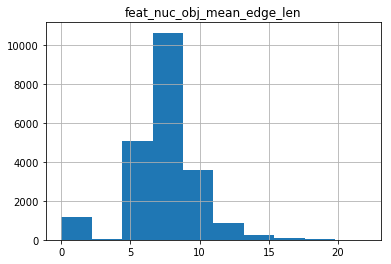

In [12]:
df.hist(column='feat_nuc_obj_mean_edge_len')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11531e490>]], dtype=object)

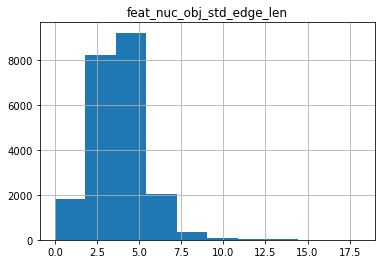

In [13]:
df.hist(column='feat_nuc_obj_std_edge_len')

In [14]:
df['feat_nuc_obj_mean_edge_len'].fillna((df['feat_nuc_obj_mean_edge_len'].mean()), inplace=True)
df['feat_nuc_obj_std_edge_len'].fillna((df['feat_nuc_obj_std_edge_len'].mean()), inplace=True)

In [15]:
for name in columns:
    if df[name].isnull().sum() > 0:
        print name, df[name].isnull().sum()

cellID 3


In [16]:
df.to_csv('data/feats_cleaned.csv', index=False)

# 4. Feature Reduction

### Random Forest to evaluate feature importances

In [17]:
feat_cols = []
for name in columns:
    if name != "structureProteinName" and name != "cellID" and name != "save_feats_path":
        feat_cols.append(name)

In [18]:
df_features = df[feat_cols]
y = df.structureProteinName.as_matrix()

In [31]:
# rf = RandomForestClassifier(n_estimators=1000,
#                            max_features='auto',
#                            random_state=0)
# rf.fit(df_features, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [20]:
rf = joblib.load('models/rf_FeatureReduction.pkl')

In [21]:
feat_scores = pd.DataFrame({'Mean_Decrease_Impurity' : rf.feature_importances_},
                           index=df_features.columns)
feat_scores = feat_scores.sort_values(by='Mean_Decrease_Impurity', ascending=False)
feat_scores[0:10]

,Mean_Decrease_Impurity
feat_cell_obj_tot_height,0.002479
feat_cell_polarity_cell_z_affinity,0.002035
feat_cell_polarity_cyto_z_affinity,0.001972
feat_cell_polarity_nuc_z_affinity,0.001758
feat_cell_region_entropy_px,0.001680
feat_cell_region_median_px,0.001632
feat_nuc_obj_tot_height,0.001604
feat_cell_region_mean_px,0.001536
feat_nuc_mt_edge_1,0.001506
feat_cell_region_std_px,0.001493


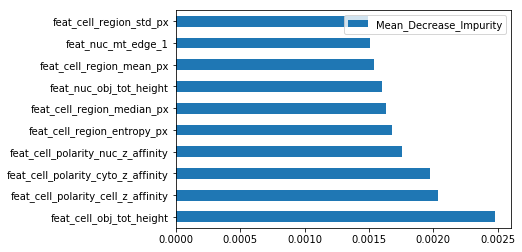

In [22]:
# Plot the feature importance: mean decrease in impurity
feat_scores[0:10].plot(kind='barh')

In [23]:
#joblib.dump(rf, 'models/rf_FeatureReduction.pkl') 

In [24]:
feat_scores.Mean_Decrease_Impurity.mean()

0.0006013229104028862

In [25]:
# How many features have mean decrease impurities of over the mean
scores_array = np.array(feat_scores.Mean_Decrease_Impurity)
((scores_array > feat_scores.Mean_Decrease_Impurity.mean())).sum()

957

In [28]:
# Reduce the dataframe to only those features
feat_scores_reduced = feat_scores[feat_scores.Mean_Decrease_Impurity>feat_scores.Mean_Decrease_Impurity.mean()]
columns_reduced = feat_scores_reduced.index.tolist()
columns_reduced.extend(["structureProteinName","cellID","save_feats_path"])

In [30]:
df_reduced = df[columns_reduced]

In [31]:
df_reduced.to_csv('data/feats_reduced_byRF.csv', index=False)